In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sartajbhuvaji_brain_tumor_classification_mri_path = kagglehub.dataset_download('sartajbhuvaji/brain-tumor-classification-mri')

print('Data source import complete.')


<h1 style="background-color:#8ffaaa;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b><u>Brain Tumor Classification</u></b></h1>


<center><img src="https://media.istockphoto.com/photos/brain-cancer-picture-id174927353?k=6&m=174927353&s=612x612&w=0&h=P3EzH6J-haFHzmKQ8RzkfotD_lsygXzNUL72Dg3pfK0=",height='300',width='600'></center>

<h1><center>INTRODUCTION TO PROBLEM OF BRAIN TUMOR</center></h1>
A Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties.

<h5 style="background-color:#f4abcd;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b>Importing Libraries</b></h5>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
import keras
from keras.applications.vgg16 import preprocess_input,VGG16
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob

# Function to convert images in folders to a dataset
def convert_image_to_dataset(file_location, folder_mapping):
    """
    Parameters:
        file_location (str): Path to the main directory containing subfolders for each category.
        folder_mapping (dict): A dictionary mapping folder names to numeric labels (e.g., {"1L": 0, "2L": 1, "3L": 2, "4L": 3}).

    Returns:
        pd.DataFrame: DataFrame with 'image' and 'label' columns.
    """

    # Initialize an empty list to store data
    all_data = []

    for folder_name, label in folder_mapping.items():
        folder_path = f"{file_location}/{folder_name}"
        print(f"Processing folder: {folder_path} with label: {label}")

        for file in tqdm(glob(f"{folder_path}/*")):
            # Load the image and resize it
            img_array = cv2.imread(file)
            if img_array is not None:  # Ensure the image is loaded successfully
                img_array = cv2.resize(img_array, (224, 224))
                # Append data to the list
                all_data.append({'image': img_array, 'label': label})
            else:
                print(f"Could not read image: {file}")

    # Create a DataFrame from the collected data
    df = pd.DataFrame(all_data)
    return df.sample(frac=1).reset_index(drop=True)

# Example usage
folder_mapping = {
    "1L": 0,
    "2L": 1,
    "3L": 2,
    "4L": 3
}

# Convert the training data into a DataFrame
train_data = convert_image_to_dataset("/content/drive/MyDrive/USLU/Labelled_train", folder_mapping)

# Convert the testing data into a DataFrame
test_data = convert_image_to_dataset("/content/drive/MyDrive/USLU/Labelled_test", folder_mapping)

# Check the resulting datasets
print(f"Training Dataset: {train_data.shape}")
print(f"Testing Dataset: {test_data.shape}")
# Function to convert output labels to its class of tumor.


def inverse_classes(num):
    if num==0:
        return '1'
    elif num==1:
        return '2'
    elif num==2:
        return '3'
    else:
        return '4'

# Convert the images from DataFrame to NumPy arrays
train_x = np.array(train_data['image'].to_list())  # Convert the image data from DataFrame to NumPy array
test_x = np.array(test_data['image'].to_list())  # Convert the image data from DataFrame to NumPy array

# Check the resulting shapes of the image arrays
print(f"train_x shape: {train_x.shape}")
print(f"test_x shape: {test_x.shape}")


Processing folder: /content/drive/MyDrive/USLU/Labelled_train/1L with label: 0


100%|██████████| 365/365 [00:17<00:00, 20.85it/s]


Processing folder: /content/drive/MyDrive/USLU/Labelled_train/2L with label: 1


100%|██████████| 365/365 [00:16<00:00, 21.67it/s]


Processing folder: /content/drive/MyDrive/USLU/Labelled_train/3L with label: 2


100%|██████████| 365/365 [00:16<00:00, 22.27it/s]


Processing folder: /content/drive/MyDrive/USLU/Labelled_train/4L with label: 3


100%|██████████| 365/365 [00:17<00:00, 21.44it/s]


Processing folder: /content/drive/MyDrive/USLU/Labelled_test/1L with label: 0


100%|██████████| 157/157 [00:09<00:00, 15.95it/s]


Processing folder: /content/drive/MyDrive/USLU/Labelled_test/2L with label: 1


100%|██████████| 101/101 [00:07<00:00, 13.85it/s]


Processing folder: /content/drive/MyDrive/USLU/Labelled_test/3L with label: 2


100%|██████████| 87/87 [01:03<00:00,  1.38it/s]


Processing folder: /content/drive/MyDrive/USLU/Labelled_test/4L with label: 3


100%|██████████| 85/85 [01:03<00:00,  1.34it/s]

Training Dataset: (1460, 2)
Testing Dataset: (430, 2)
train_x shape: (1460, 224, 224, 3)
test_x shape: (430, 224, 224, 3)


In [ ]:
# Function to convert output labels to its class of tumor.


def inverse_classes(num):
    if num==0:
        return '1'
    elif num==1:
        return '2'
    elif num==2:
        return '3'
    else:
        return '4'


In [ ]:
# Check the columns of train_data to ensure 'image' is present
print(train_data.columns)


Index(['image', 'label'], dtype='object')


In [ ]:
# train_data=convert_image_to_dataset('')
# train_x=np.array(train_data.image.to_list())

AttributeError: 'DataFrame' object has no attribute 'image'

In [ ]:
# test_data=convert_image_to_dataset('/content/drive/MyDrive/USLU/Labelled_test')
# test_x=np.array(test_data.image.to_list())

<h1 style="background-color:#f4abcd;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b>Visualizing Dataset</b></h1>


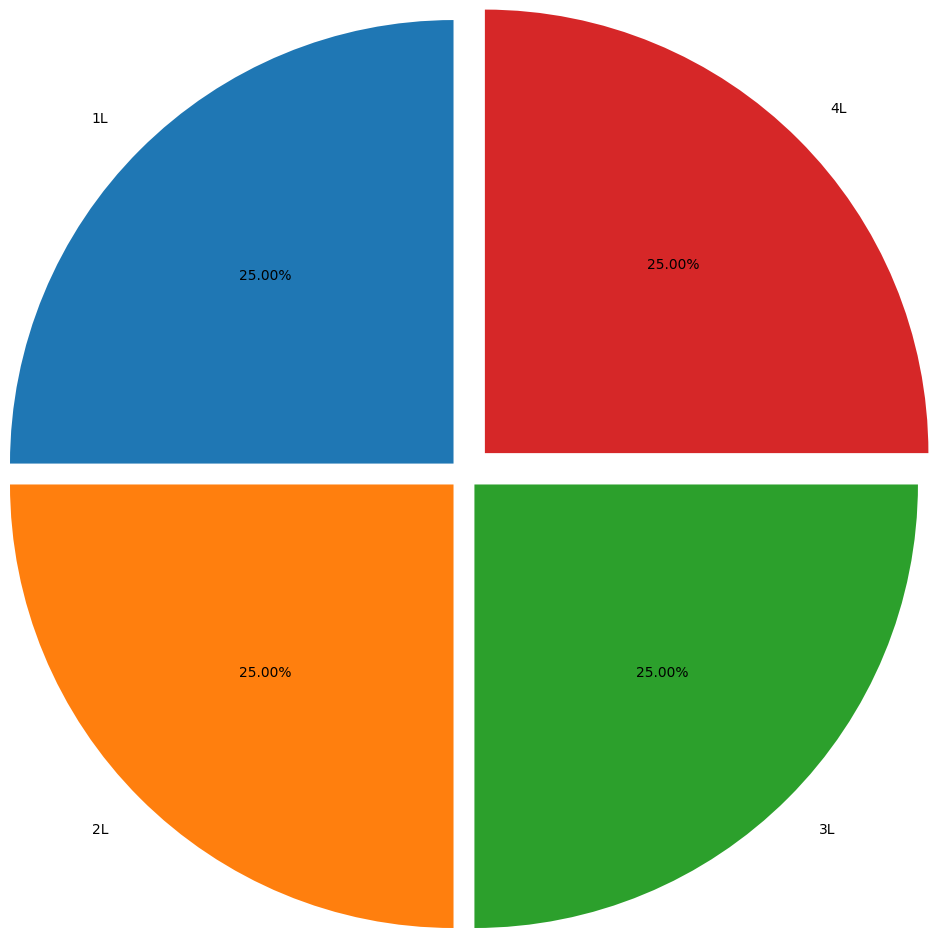

In [ ]:
plt.pie(train_data.label.value_counts(),startangle=90,explode=[0.1,0.1,0.1,0.2],autopct='%0.2f%%',
        labels=['1L', '2L', '3L', '4L'],radius=3)
plt.show()

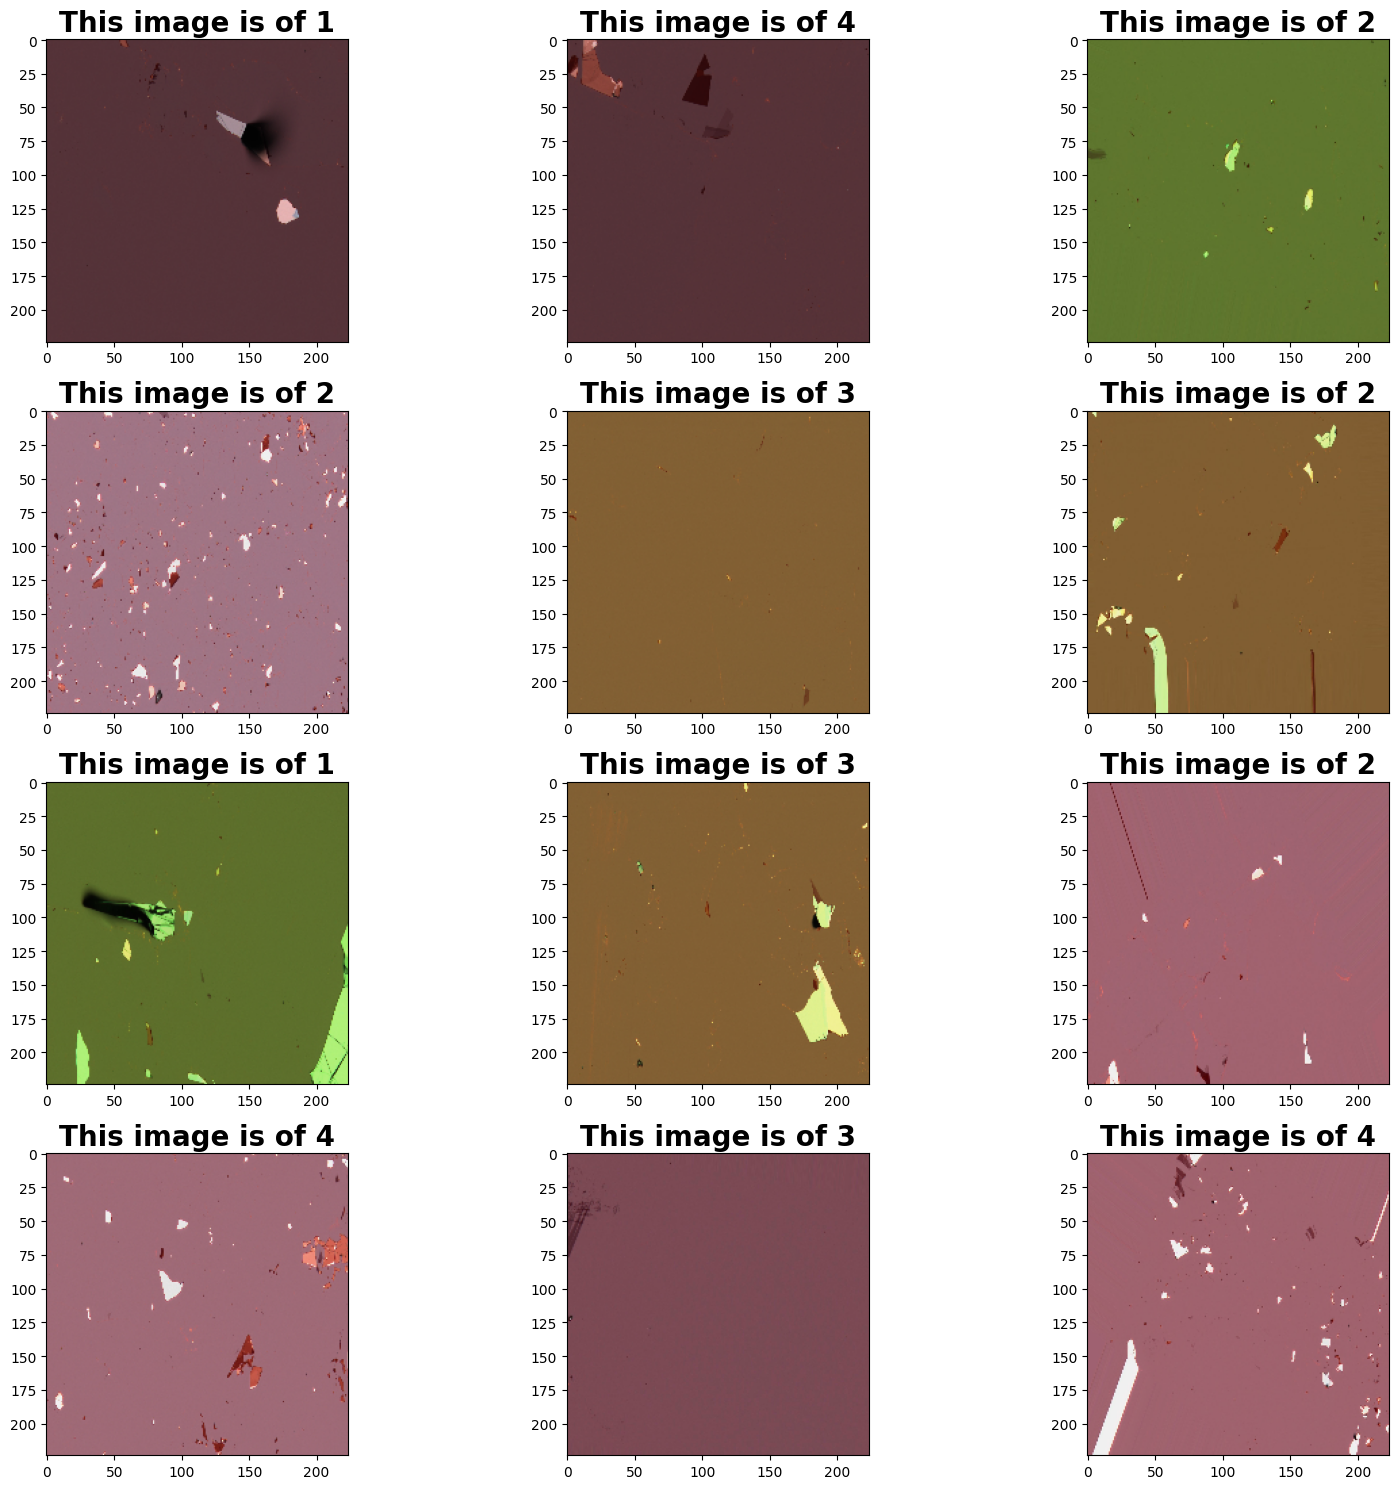

In [ ]:
plt.figure(figsize=(20, 15))
for i in range(12):
    plt.subplot(4, 3, i + 1)  # Use (i + 1) for subplot index
    index = np.random.randint(len(train_data))  # Random index based on train_data size
    label_name = inverse_classes(train_data.label[index])  # Convert label to class name
    plt.title(f'This image is of {label_name}', fontdict={'size': 20, 'weight': 'bold'})
    plt.imshow(train_data.image[index])
    plt.tight_layout()
plt.show()


<h1 style="background-color:#f4abcd;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b>Callbacks Functions</b></h1>


In [ ]:
early_stop=EarlyStopping(patience=3)
reduceLR=ReduceLROnPlateau(patience=2)

In [ ]:
# import tensorflow as tf

# # Check if a GPU is available
# device_name = tf.test.gpu_device_name()

# if device_name != '/device:GPU:0':
#     print('No GPU found, using CPU instead.')
# else:
#     print(f'GPU found: {device_name}')

# # Use MirroredStrategy if you want to utilize multiple GPUs (if available)
# strategy = tf.distribute.MirroredStrategy()

# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


GPU found: /device:GPU:0
Number of devices: 1


# Here we are going to explore two processes by which we could solve this problem,

1. Traditional CNN Approach

2. Transfer Learning Approach

<h4 style="background-color:#f4a123;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px" ><b>Traditional CNN Approach</b></h4>


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

# Use GPU if available
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    print('No GPU found, using CPU instead.')
else:
    print(f'GPU found: {device_name}')

# Use MirroredStrategy for multi-GPU setups (if available)
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Instantiate the model inside the strategy scope
with strategy.scope():
    model_cnn = Sequential()
    model_cnn.add(Input(shape=(224, 224, 3)))
    model_cnn.add(Conv2D(128, (3, 3)))
    model_cnn.add(MaxPooling2D((2, 2)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(64, (3, 3)))
    model_cnn.add(MaxPooling2D((2, 2)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(32, (3, 3)))
    model_cnn.add(MaxPooling2D((2, 2)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu'))
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(64, activation='relu'))
    model_cnn.add(Dense(4, activation='softmax'))

    model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_cnn.summary()


GPU found: /device:GPU:0
Number of devices: 1


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 111, 111, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,874,276 (10.96 MB)

 Trainable params: 2,873,828 (10.96 MB)

 Non-trainable params: 448 (1.75 KB)

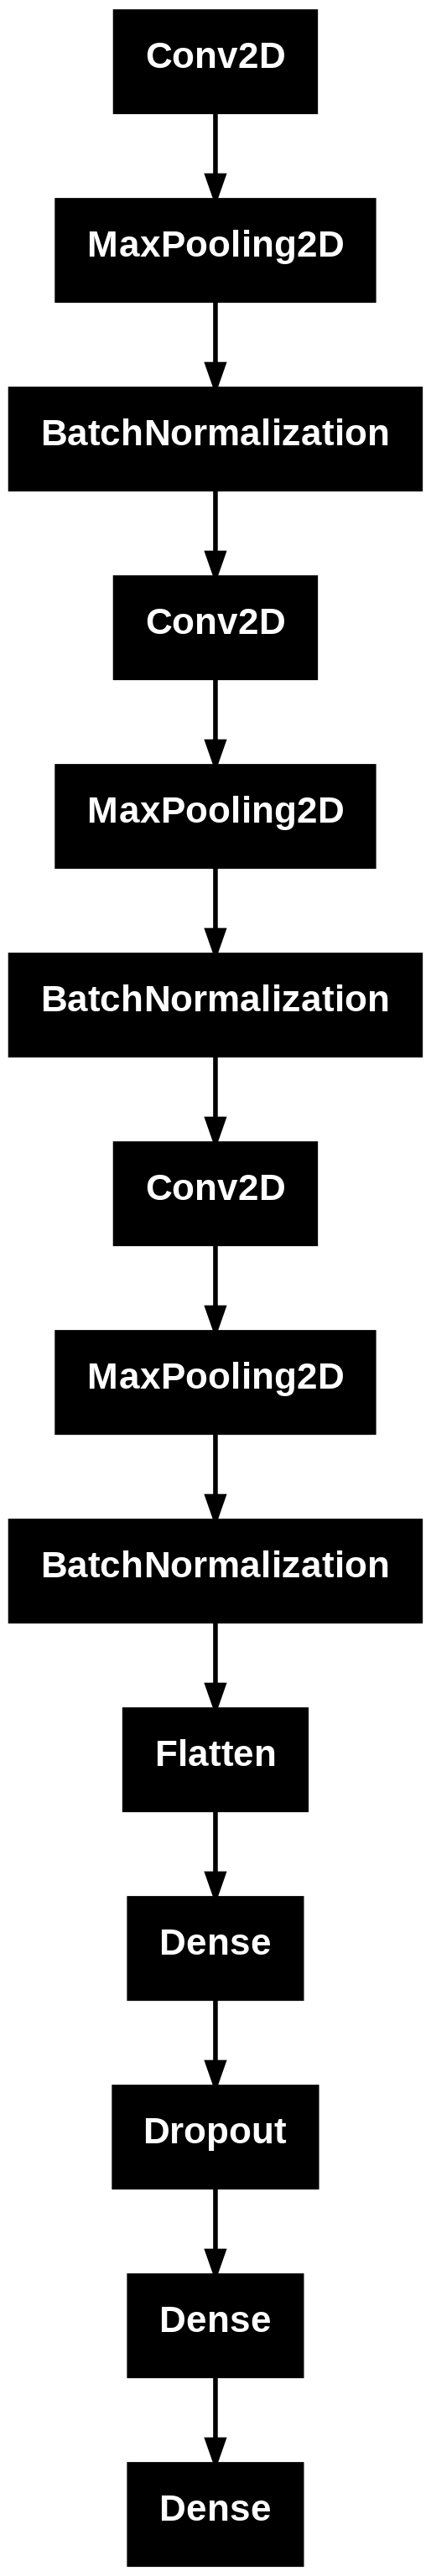

In [ ]:
from tensorflow.keras.utils import plot_model # Make sure this import is at the top of your script

# ... (rest of your code) ...

# After defining and compiling your model (model_cnn)
plot_model(model_cnn)

In [ ]:
r1=model_cnn.fit(train_x,train_data.label,validation_split=0.1,epochs=50,callbacks=[reduceLR])

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.8210 - loss: 0.4707 - val_accuracy: 0.3356 - val_loss: 2.0953 - learning_rate: 1.0000e-08
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.8002 - loss: 0.5017 - val_accuracy: 0.3425 - val_loss: 2.0993 - learning_rate: 1.0000e-08
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.8134 - loss: 0.4820 - val_accuracy: 0.3425 - val_loss: 2.0966 - learning_rate: 1.0000e-08
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.8058 - loss: 0.5027 - val_accuracy: 0.3425 - val_loss: 2.1000 - learning_rate: 1.0000e-09
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.8094 - loss: 0.4986 - val_accuracy: 0.3356 - val_loss: 2.0940 - learning_rate: 1.0000e-09
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.8117 - loss: 0.4780 - val_accuracy: 0.3356 - val_loss: 2.0937 - learning_rate: 1.0000e-09
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 

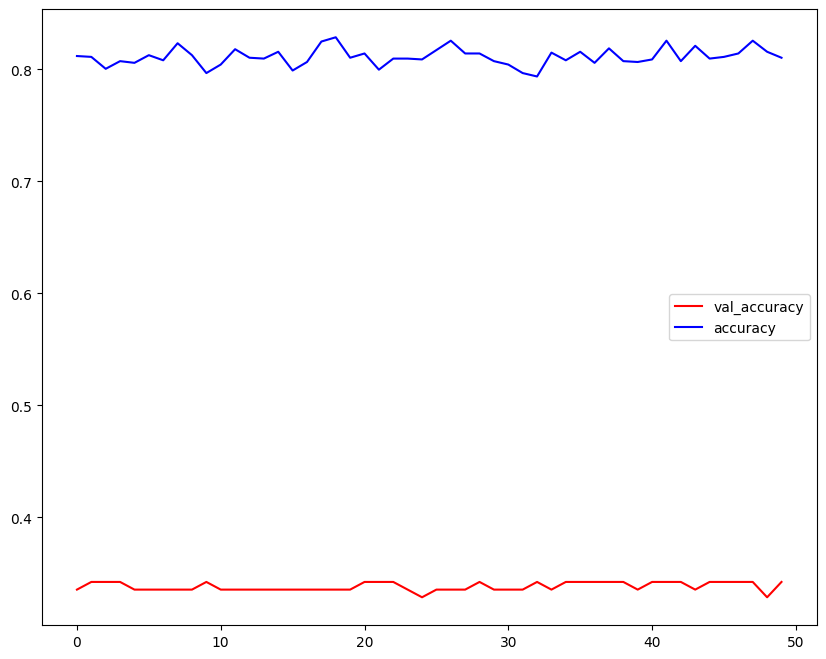

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r1.history['val_accuracy'], color='red')  # Change color of validation accuracy line
plt.plot(r1.history['accuracy'], color='blue')    # Change color of training accuracy line
plt.legend(['val_accuracy','accuracy'])
plt.show()


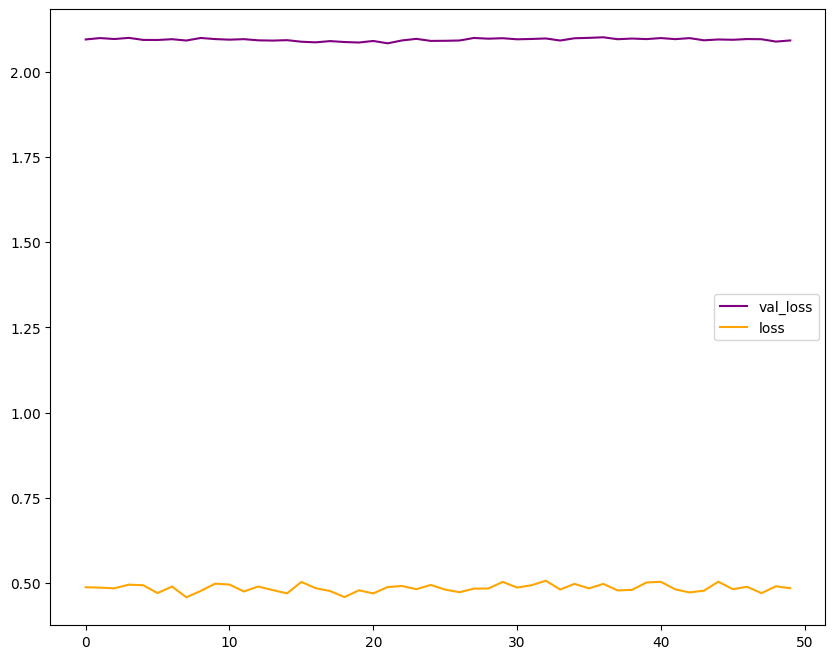

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r1.history['val_loss'], color='purple')  # Change color of validation loss line
plt.plot(r1.history['loss'], color='orange')     # Change color of training loss line
plt.legend(['val_loss','loss'])
plt.show()



In [ ]:
# Predictions on Test Datasets using CNN model

test_pred=np.argmax(model_cnn.predict(test_x),axis=1)
print(classification_report(test_data.label,test_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
              precision    recall  f1-score   support

           0       0.37      0.38      0.37       157
           1       0.27      0.18      0.22       101
           2       0.19      0.18      0.19        87
           3       0.23      0.33      0.27        85

    accuracy                           0.28       430
   macro avg       0.27      0.27      0.26       430
weighted avg       0.28      0.28      0.28       430



<h5 style="background-color:#f4a123;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px" ><b>Transfer Learning Approach (VGG 16)</b></h5>


## What is Transfer Learning?

Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.
    In case of image processing we use some pretrained models like VGG-16,RasNet,VGG-19,etc. Which is trained on large ImageNet dataset.

## What is imagenet?

The ImageNet project is a large visual database designed for use in visual object recognition software research. More than 14 million images have been hand-annotated by the project to indicate what objects are pictured and in at least one million of the images, bounding boxes are also provided. ImageNet contains more than 20,000 categories with a typical category, such as "balloon" or "strawberry", consisting of several hundred images.
    Here we use VGG-16 to train our model.
    
## What is VGG-16?

VGG16 (also called OxfordNet) is a convolutional neural network architecture named after the Visual Geometry Group from Oxford, who developed it. It was used to win the ILSVR (ImageNet) competition in 2014. VGG-16 is a convolutional neural network that is 16 layers deep. The network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Step 1: Load the VGG16 model without the top layers (include_top=False)
vgg_model = VGG16(weights='imagenet', include_top=False)

# Step 2: Freeze all VGG16 layers so that their weights won't be updated during training
for layer in vgg_model.layers:
    layer.trainable = False

# Step 3: Add custom layers on top of the VGG16 base model
x = vgg_model.output
x = GlobalAveragePooling2D()(x)  # Apply Global Average Pooling to reduce dimensions
x = Dense(128, activation='relu')(x)  # Fully connected layer with 128 units
x = Dropout(0.15)(x)  # Dropout layer to prevent overfitting
output = Dense(4, activation='softmax')(x)  # Output layer for 4 classes

# Step 4: Create the final model with VGG16 input and custom output
model2 = Model(inputs=vgg_model.input, outputs=output)

# Step 5: Compile the model with the Adam optimizer and sparse categorical cross-entropy loss
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Now the model is ready to be trained


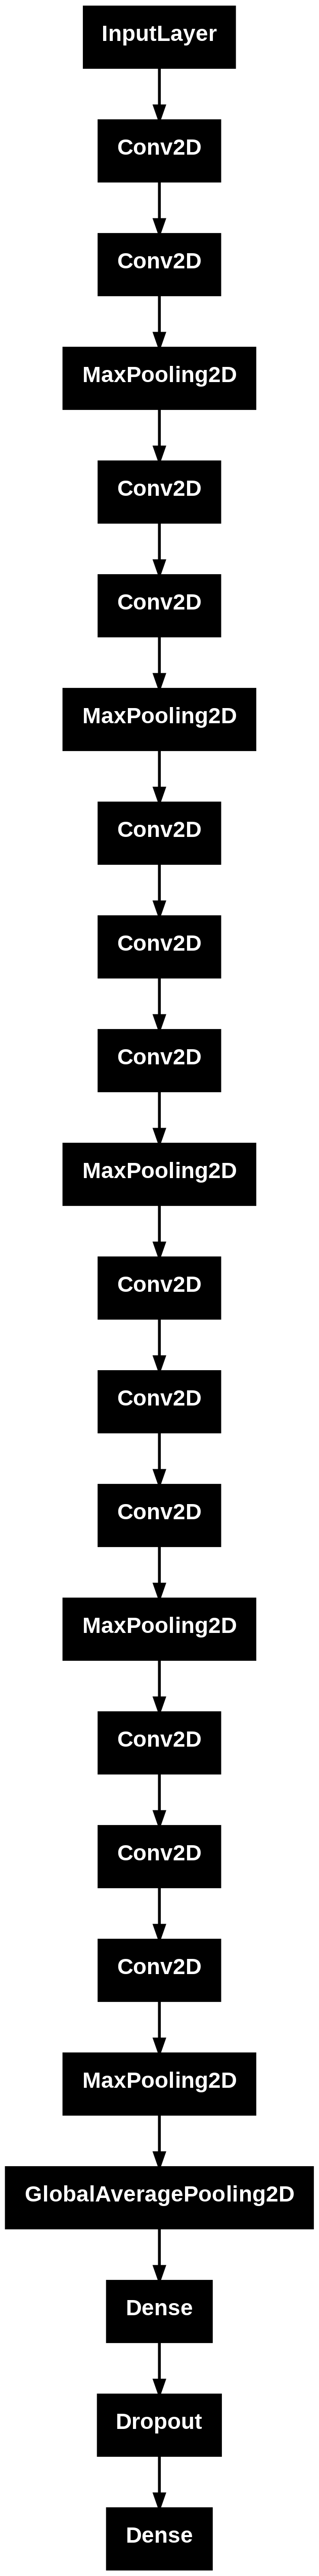

In [ ]:
plot_model(model2)

In [ ]:
r2=model2.fit(train_x,train_data.label,validation_split=0.1,epochs=50,callbacks=[early_stop,reduceLR])

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1017s 24s/step - accuracy: 0.2810 - loss: 2.5404 - val_accuracy: 0.2671 - val_loss: 1.5126 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 974s 23s/step - accuracy: 0.3564 - loss: 1.5108 - val_accuracy: 0.2671 - val_loss: 1.4597 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 981s 23s/step - accuracy: 0.3987 - loss: 1.3158 - val_accuracy: 0.3082 - val_loss: 1.3915 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 941s 22s/step - accuracy: 0.4575 - loss: 1.2057 - val_accuracy: 0.3904 - val_loss: 1.3338 - learning_rate: 0.0010
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1029s 24s/step - accuracy: 0.4861 - loss: 1.1401 - val_accuracy: 0.3836 - val_loss: 1.3199 - learning_rate: 0.0010
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 941s 22s/step - accuracy: 0.5425 - loss: 1.0798 - val_accuracy: 0.3973 - val_loss: 1.3321 - learning_rate: 0.0010
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 995s 24s/step - accuracy: 0.5532 - loss: 1.0330 

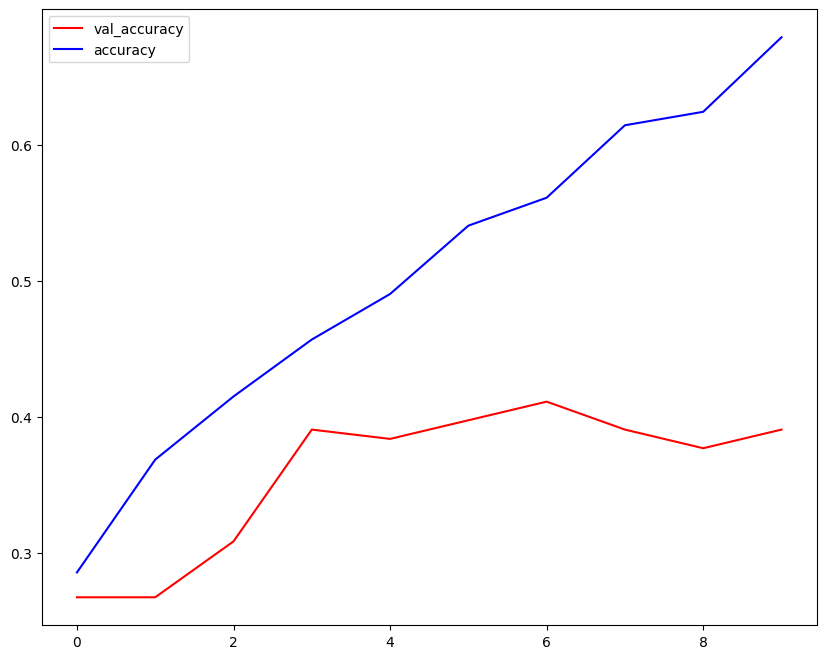

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r2.history['val_accuracy'],  color='red')
plt.plot(r2.history['accuracy'],  color='blue')
plt.legend(['val_accuracy','accuracy'])
plt.show()

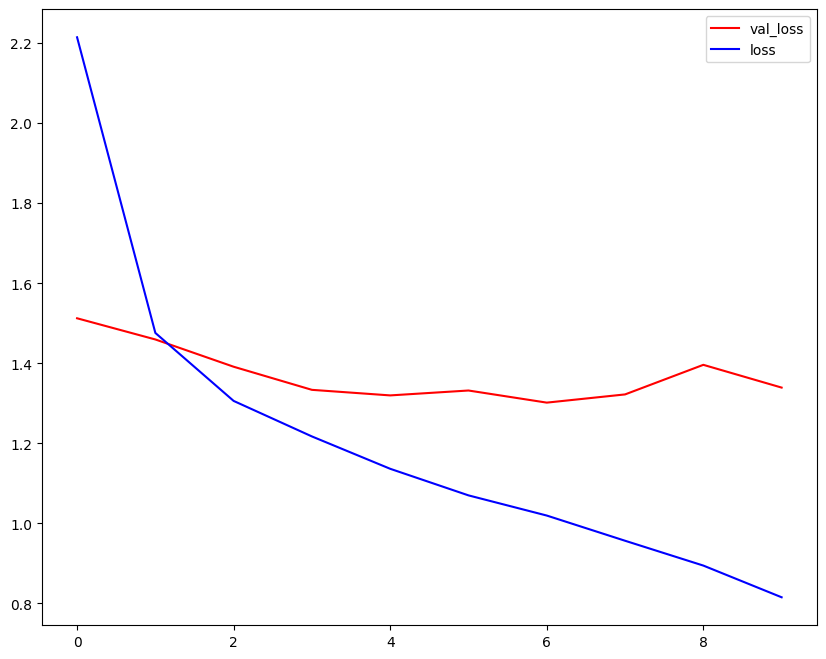

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r2.history['val_loss'],  color='red')
plt.plot(r2.history['loss'],  color='blue')
plt.legend(['val_loss','loss'])
plt.show()

In [ ]:
# Predictions on Test Datasets using VGG16 model

test_pred_transfer=np.argmax(model2.predict(test_x),axis=1)
print(classification_report(test_data.label,test_pred_transfer))

14/14 ━━━━━━━━━━━━━━━━━━━━ 286s 20s/step
              precision    recall  f1-score   support

           0       0.45      0.47      0.46       157
           1       0.26      0.22      0.24       101
           2       0.22      0.24      0.23        87
           3       0.20      0.19      0.19        85

    accuracy                           0.31       430
   macro avg       0.28      0.28      0.28       430
weighted avg       0.31      0.31      0.31       430



<h5 style="background-color:#a4adcb;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px" ><b>Visualizing Prediction on test dataset</b></h5>


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


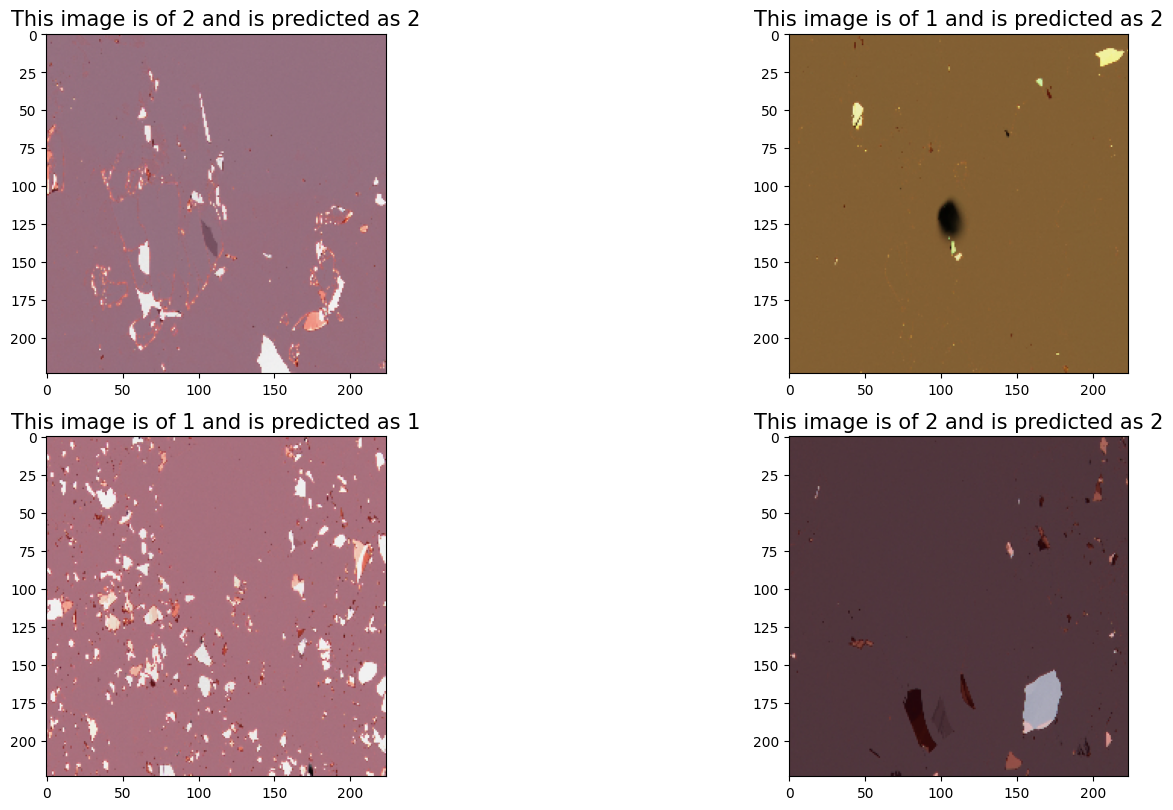

In [ ]:
# Prediction using VGG16 model

plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(200)
    pred_class=inverse_classes(np.argmax(model2.predict(np.reshape(test_x[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(test_data.label[index]),pred_class),
              fontdict={'size':15})
    plt.imshow(test_x[index])
    plt.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


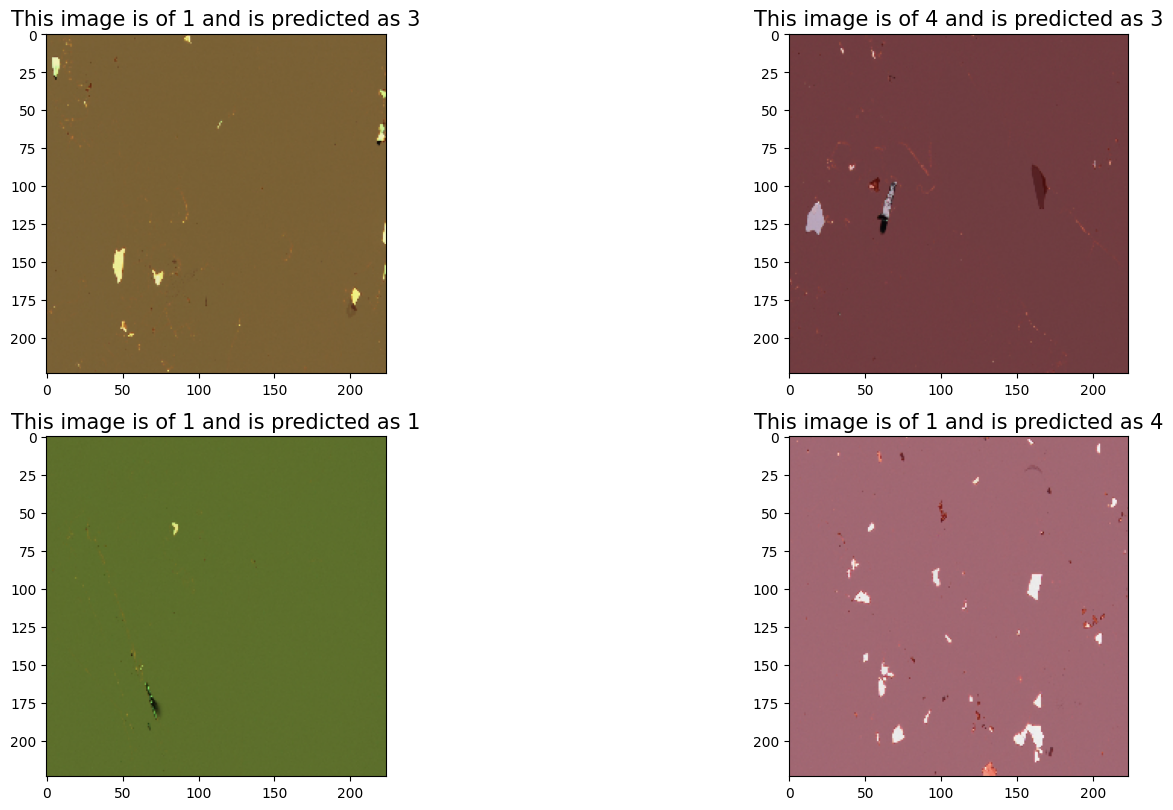

In [ ]:
# Prediction using CNN model

plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(200)
    pred_class=inverse_classes(np.argmax(model_cnn.predict(np.reshape(test_x[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(test_data.label[index]),pred_class),
              fontdict={'size':15})
    plt.imshow(test_x[index])
    plt.tight_layout()

<h5 style="background-color:#a41234;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px" ><b>Conclusion</b></h5>


## Here We could clearly observe that both the approaches worked quite well, with not much difference in accuracy. Though VGG16 model worked quite more efficiently, Because of two reasons:-
1. The validation accuracy and test accuracy is higher than the other method.
2. Time of computation and computation power is required lesser than traditional method as pretrained weights are used.

## <i>If you liked the notebook do upvote it. If having any queries or suggestion ,write in the comment section below.</i>